In [1]:
import os
# Utility imports
import rfa_utils.general_fns as gf
import rfa_utils.owlracle_api as oa
import rfa_utils.clean_crypto as cc
import rfa_utils.coingecko_api as ca
# EDA imports
import rfa_eda.crypto_eda as ceda
import rfa_eda.stablecoin_eda as seda

In [2]:
# List of stablecoin symbols and IDs
syms = ['usdt', 'usdc', 'busd', 'dai', 'tusd', 'usdp', 'gusd']
sids = ['tether', 'usd-coin', 'binance-usd', 'dai', 'true-usd', 'paxos-standard', 'gemini-dollar']

# Variables for API call
currency = 'usd'
start_date = '2019/01/01'
end_date = '2022/12/31'

In [3]:
# Check and create API data
api_path = os.path.join('data/stablecoin/', 'api-data.xlsx')
gf.check_and_create(api_path, ca.create_api_dict, syms, sids, currency, start_date, end_date)

In [4]:
# Check and create fees data
fees_path = os.path.join('data/stablecoin/', 'fees-data.xlsx')
gf.check_and_create(fees_path, oa.create_df, start_date, end_date)

In [5]:
# Check and create combined file
combined_path = os.path.join('data/stablecoin/', 'combined-data.xlsx')
if not os.path.exists(combined_path):
    # Import Excel files into variables
    api_import = gf.import_excel(
        'data/stablecoin/filled-api-data.xlsx',
        syms
    )
    fees_import = gf.import_excel(
        'data/stablecoin/fees-data.xlsx',
        ['Sheet1']
    )
    # Add the fees dataframe to the API data
    api_import['fees'] = fees_import['Sheet1']
    # Create Excel file with combined data
    gf.create_excel(combined_path, api_import)

In [6]:
# Check and create imputed file
imputed_path = os.path.join('data/stablecoin/', 'imputed-data.xlsx')
if not os.path.exists(imputed_path):
    # Import combined data
    syms.append('fees')
    combined = gf.import_excel(
        combined_path,
        syms
    )
    # Impute missing values
    imputed = cc.impute_dfs(combined, ['busd', 'dai'])
    # Winsorize fees column
    imputed['fees'] = cc.winsorize_df(imputed['fees'], (0.01, 0.01))
    # Create Excel
    gf.create_excel(imputed_path, imputed)

In [7]:
# Import imputed dataframes
syms.append('fees')
imputed = gf.import_excel(
    imputed_path,
    syms
)
# Convert to pandas
for df in imputed:
    imputed[df] = imputed[df].to_pandas()

In [8]:
# Print summary stats
ceda.summary_stats(imputed)

>>> USDT
╒═══════╤═════════════════════╤══════════╤═════════════════╤══════════════════╕
│       │ date                │   prices │     market_caps │       24h_volume │
╞═══════╪═════════════════════╪══════════╪═════════════════╪══════════════════╡
│ count │ 1461                │ 1461.000 │        1461.000 │         1461.000 │
├───────┼─────────────────────┼──────────┼─────────────────┼──────────────────┤
│ mean  │ 2020-12-31 00:00:00 │    1.001 │ 35646986164.927 │  18720967145.791 │
├───────┼─────────────────────┼──────────┼─────────────────┼──────────────────┤
│ min   │ 2019-01-01 00:00:00 │    0.982 │  2037015238.617 │    747000000.000 │
├───────┼─────────────────────┼──────────┼─────────────────┼──────────────────┤
│ 25%   │ 2020-01-01 00:00:00 │    1.000 │  4287222687.765 │   5140000000.000 │
├───────┼─────────────────────┼──────────┼─────────────────┼──────────────────┤
│ 50%   │ 2020-12-31 00:00:00 │    1.000 │ 20920738588.994 │  11160000000.000 │
├───────┼─────────────────────┼

In [9]:
# Print transaction fees standard deviation, skewness, and kurtosis
seda.fees_stats(imputed['fees'])

╒══════════════════╤════════╤════════╤════════╕
│                  │    std │   skew │   kurt │
╞══════════════════╪════════╪════════╪════════╡
│ transaction_fees │ 15.042 │  2.711 │  8.308 │
╘══════════════════╧════════╧════════╧════════╛


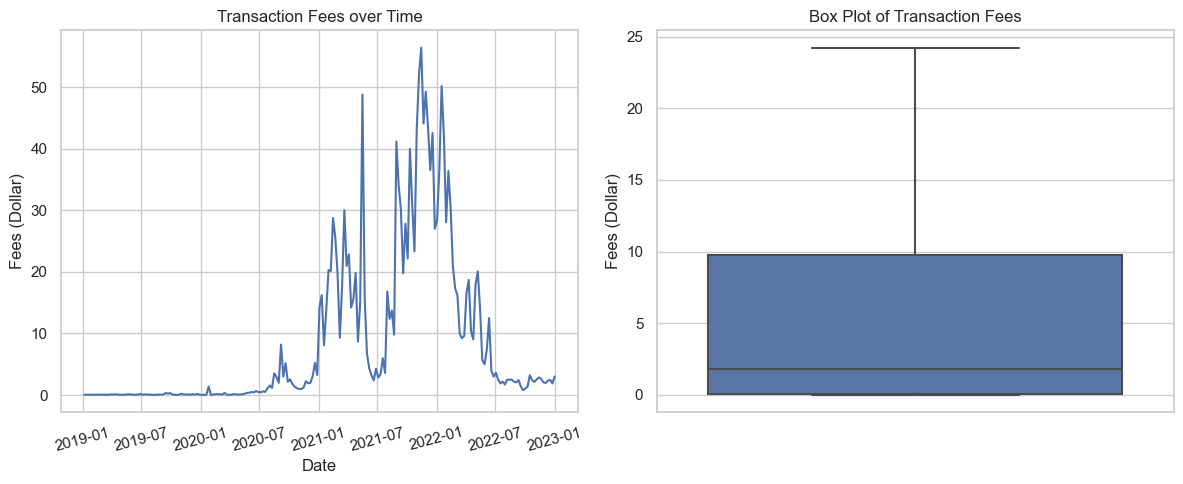

In [10]:
# Plot line plot and box plot for transaction fees
seda.fees_plots(imputed['fees'])

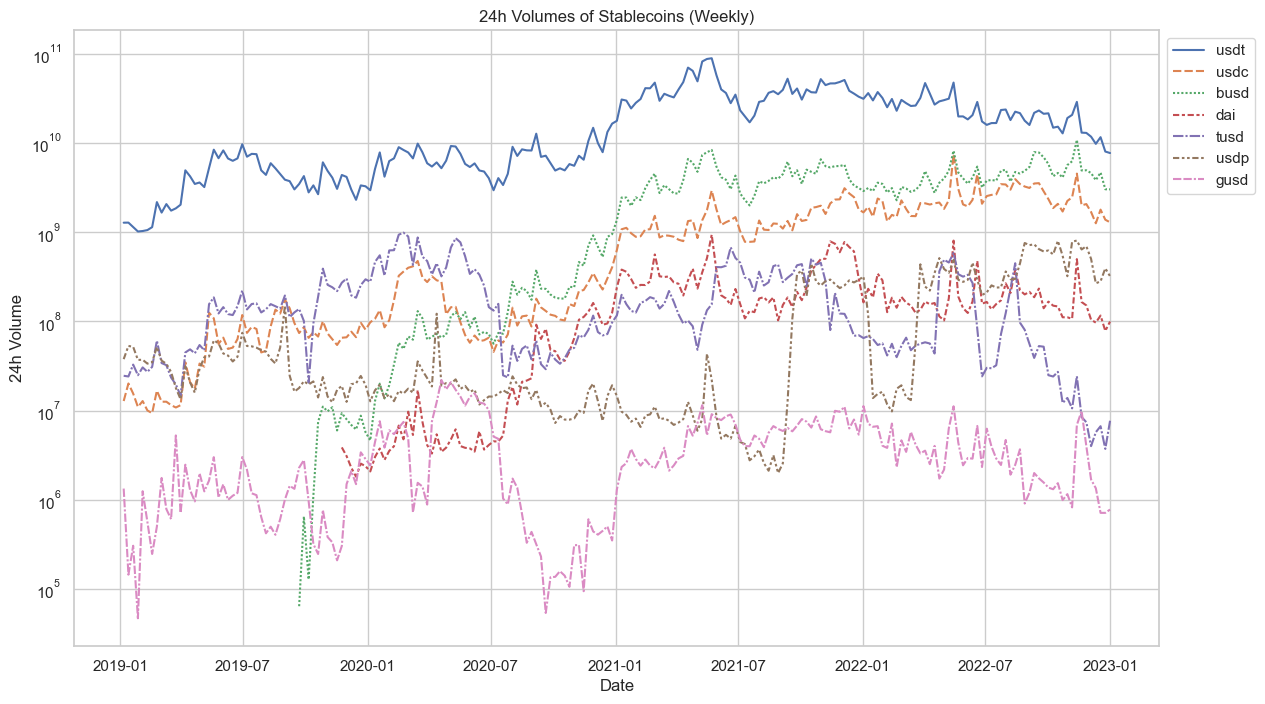

In [11]:
# Plot line plots for each token's volume
seda.volumes_lineplot(imputed)

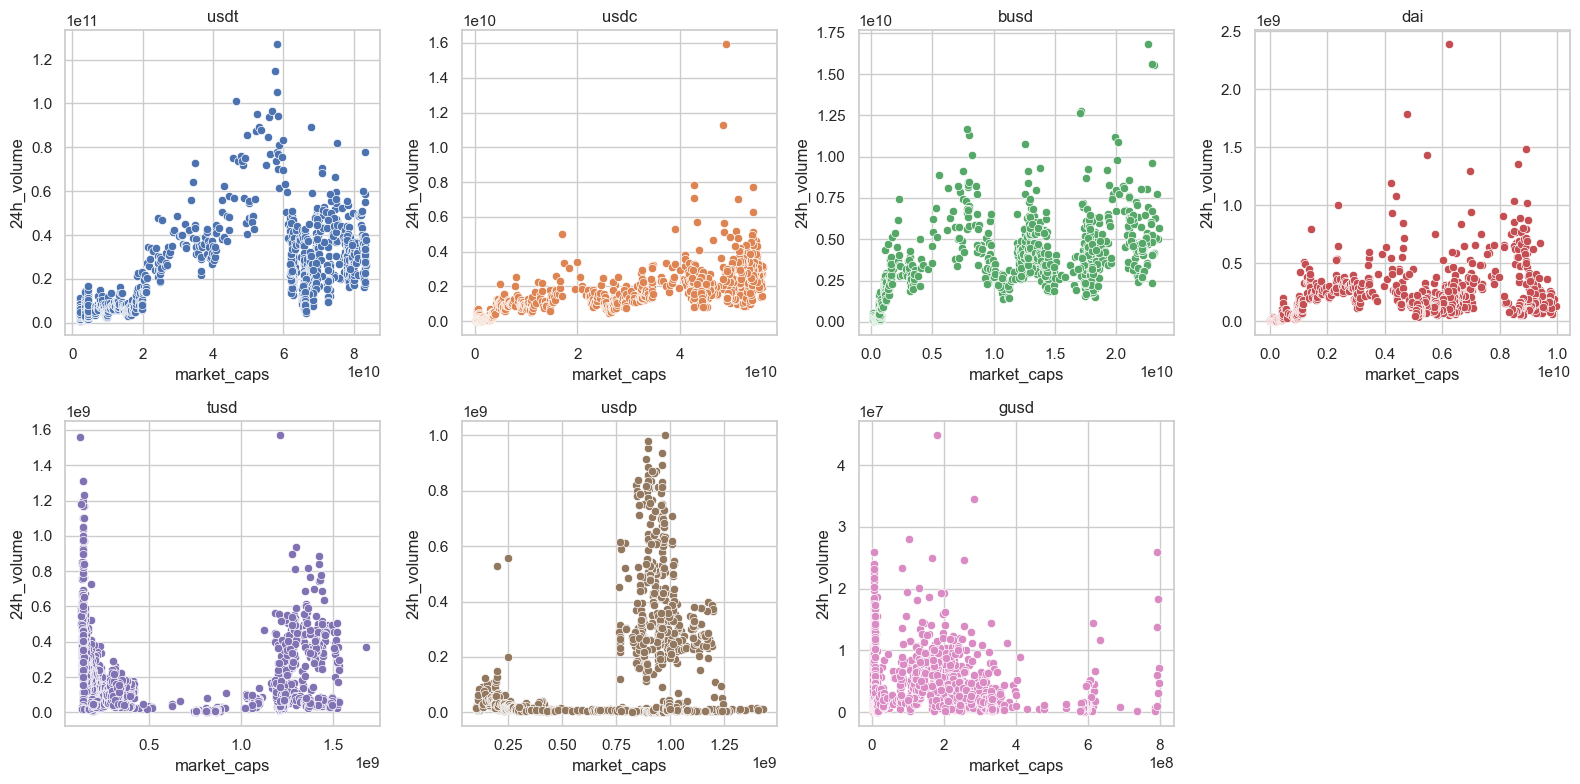

In [12]:
# Plot scatterplots of volumes vs market caps
seda.mcaps_volumes_scatterplots(imputed)